# Mérlegeljük a modellillesztés problémáját

## Válasszuk szét a gyakorló és a teszthalmazt

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

def kaliforniai_lakásadatok_betöltése():
    adathalmaz = fetch_california_housing()
    X = pd.DataFrame(data=adathalmaz.data,
                     columns=adathalmaz.feature_names)
    y = pd.Series(data=adathalmaz.target, name="cél")
    return X, y

X, y = kaliforniai_lakásadatok_betöltése()

print(X.shape, y.shape)

(20640, 8) (20640,)


In [2]:
from sklearn.neighbors import KNeighborsRegressor

knn_modell = KNeighborsRegressor(n_jobs=-1)
knn_modell.fit(X, y)

r2 = knn_modell.score(X, y)

print(f"R négyzet érték: {r2:.2f}")

R négyzet érték: 0.47


In [3]:
from sklearn.model_selection import train_test_split

X_tanító, X_teszt, y_tanító, y_teszt = train_test_split(
    X, y, test_size=0.20, random_state=0)

print(f"A tanító halmaz formája: {X_tanító.shape}")
print(f"A teszthalmaz formája: {X_teszt.shape}")

A tanító halmaz formája: (16512, 8)
A teszthalmaz formája: (4128, 8)


In [4]:
from sklearn.metrics import mean_squared_error

knn_modell.fit(X_tanító, y_tanító)

előrejelzések_tanító = knn_modell.predict(X_tanító)
előrejelzések_teszt = knn_modell.predict(X_teszt)

tanító_ánh = mean_squared_error(y_true=y_tanító,
                                y_pred=előrejelzések_tanító) 
print(f"A tanító halmaz átlagos négyzetes hibája: {tanító_ánh:.5f}")

A tanító halmaz átlagos négyzetes hibája: 0.73442


In [5]:
teszt_ánh = mean_squared_error(y_true=y_teszt, 
                               y_pred=előrejelzések_teszt)
print(f"A teszthalmaz átlagos négyzetes hibája: {teszt_ánh:.5f}")

A teszthalmaz átlagos négyzetes hibája: 1.11733


# Végezzünk keresztvalidációt

## Végezzünk keresztvalidációt k adatrészen

In [6]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

ke = KFold(n_splits=10, shuffle=True, random_state=0)
pontszámok = cross_val_score(knn_modell, X, y, cv=ke,   
                             scoring='neg_mean_squared_error', n_jobs=-1)
ánh_átlag = np.mean(np.abs(pontszámok))
ánh_szórás = np.std(pontszámok)

print(f"keresztvalidáció átlagos négyzetes hibája: {ánh_átlag:.5f} szórás: {ánh_szórás:.5f}")

keresztvalidáció átlagos négyzetes hibája: 1.10818 szórás: 0.02739


## Vegyünk rétegzett mintát az összetett adatokból

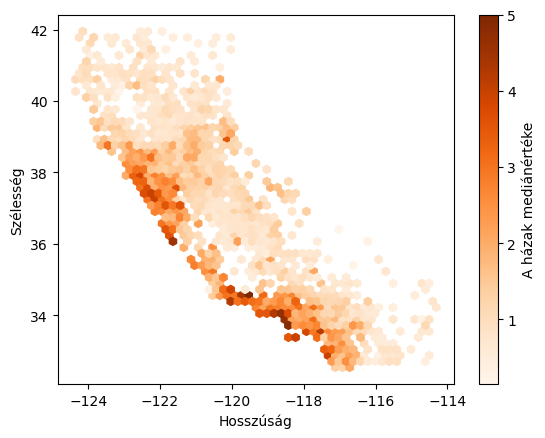

In [7]:
import matplotlib.pyplot as dg
import pandas as pd

dg.hexbin(X.Longitude, X.Latitude, C=y, gridsize=50,            
          cmap='Oranges')
szs = dg.colorbar()
szs.set_label('A házak mediánértéke')
dg.xlabel('Hosszúság'); dg.ylabel('Szélesség'); dg.show()

see: https://www.kaggle.com/competitions/playground-series-s3e1/discussion/376210
https://www.kaggle.com/code/dmitryuarov/ps-s3e1-coordinates-key-to-victory

In [8]:
from sklearn.cluster import KMeans

koordináták = X[["Latitude","Longitude"]]

klaszterezés = KMeans(n_clusters=20, n_init=10,
                    random_state=0)
klaszterezés.fit(koordináták)

terület = klaszterezés.predict(koordináták)

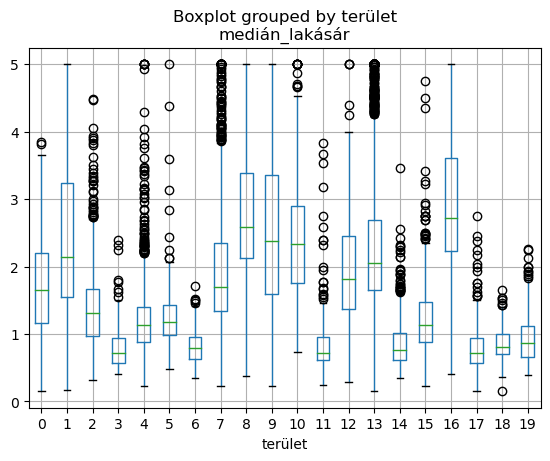

In [9]:
ak_terület = pd.DataFrame({"terület": terület, "medián_lakásár": y})
ak_terület.boxplot("medián_lakásár", by="terület");

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

rka = StratifiedKFold(n_splits=10, shuffle=True,
                      random_state=0)
pontszámok = list()

for tanító_index, teszt_index in rka.split(X, terület):
    X_tanító, X_teszt = X.iloc[tanító_index], \
        X.iloc[teszt_index]
    y_tanító, y_teszt = y[tanító_index], y[teszt_index]
    knn_modell.fit(X_tanító, y_tanító)
    y_előrejelzés = knn_modell.predict(X_teszt)
    pontszámok.append(mean_squared_error(y_true=y_teszt,
                                     y_pred=y_előrejelzés))

print('%ix keresztvalidáció átlagos négyzetes hibája: %.5f szórás: %.5f' %
      (len(pontszámok),np.mean(np.abs(pontszámok)),
       np.std(pontszámok)))

10x keresztvalidáció átlagos négyzetes hibája: 1.09899 szórás: 0.04505


# Válasszuk ki a változókat profi módon

In [11]:
ak_terület = pd.get_dummies(terület, prefix="terület")
ak_X = pd.concat([X, ak_terület], axis=1)

## Válasszunk egyváltozós mérőszámok alapján

In [12]:
from sklearn.feature_selection import r_regression

korrelációk = r_regression(ak_X, y)
for n, s in zip(ak_X.columns, korrelációk):
    print(f"F-pontszám: {s:+2.3f} a(z) {n} jellemző esetében")

F-pontszám: +0.688 a(z) MedInc jellemző esetében
F-pontszám: +0.106 a(z) HouseAge jellemző esetében
F-pontszám: +0.152 a(z) AveRooms jellemző esetében
F-pontszám: -0.047 a(z) AveBedrms jellemző esetében
F-pontszám: -0.025 a(z) Population jellemző esetében
F-pontszám: -0.024 a(z) AveOccup jellemző esetében
F-pontszám: -0.144 a(z) Latitude jellemző esetében
F-pontszám: -0.046 a(z) Longitude jellemző esetében
F-pontszám: -0.047 a(z) terület_0 jellemző esetében
F-pontszám: +0.188 a(z) terület_1 jellemző esetében
F-pontszám: -0.129 a(z) terület_2 jellemző esetében
F-pontszám: -0.155 a(z) terület_3 jellemző esetében
F-pontszám: -0.167 a(z) terület_4 jellemző esetében
F-pontszám: -0.065 a(z) terület_5 jellemző esetében
F-pontszám: -0.111 a(z) terület_6 jellemző esetében
F-pontszám: -0.025 a(z) terület_7 jellemző esetében
F-pontszám: +0.101 a(z) terület_8 jellemző esetében
F-pontszám: +0.158 a(z) terület_9 jellemző esetében
F-pontszám: +0.045 a(z) terület_10 jellemző esetében
F-pontszám: -0.10

## Alkalmazzunk előre és hátrafelé haladó kiválasztást

In [13]:
%%time
from sklearn.feature_selection \
    import SequentialFeatureSelector

kiválasztó = SequentialFeatureSelector(
    estimator=knn_modell,
    direction='forward',
    cv=3,
    scoring='neg_mean_squared_error',
    n_features_to_select=14
)

kiválasztó.fit(ak_X, y)
jellemzőmaszk = kiválasztó.support_
kiválasztott = [feature for feature,
            support in zip(ak_X.columns,
                           jellemzőmaszk) if support]
print(f"Kiválasztott jellemzők: {kiválasztott}")

Kiválasztott jellemzők: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'terület_0', 'terület_3', 'terület_4', 'terület_5', 'terület_8', 'terület_10', 'terület_14', 'terület_17', 'terület_19']
CPU times: total: 8.2 s
Wall time: 1min 14s


# Turbózzuk fel a hiperparamétereket

## Valósítsuk meg a rácskeresést

In [14]:
knn_modell = KNeighborsRegressor(n_jobs=1)

In [15]:
param_rács = {'n_neighbors': [1, 3, 5, 7, 10, 25, 50, 100],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'cosine']}

In [16]:
from sklearn.model_selection import cross_val_score

pontozási_metrika = 'neg_mean_squared_error'
pontszámok = cross_val_score(
   knn_modell, X=ak_X.loc[:, jellemzőmaszk], y=y,
   cv=10, scoring=pontozási_metrika, n_jobs=-1)

alappontszám = np.mean(np.abs(pontszámok))
print(f"Alappontszám alapértelmezett paraméterekkel: {alappontszám:.3f}")

Alappontszám alapértelmezett paraméterekkel: 0.538


In [17]:
%%time
from sklearn.model_selection import GridSearchCV

keresés = GridSearchCV(
    estimator=knn_modell,
    param_grid=param_rács,
    scoring=pontozási_metrika,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    cv=10
)

keresés.fit(ak_X.loc[:, jellemzőmaszk], y)

CPU times: total: 3.61 s
Wall time: 7min 3s


GridSearchCV(cv=10, estimator=KNeighborsRegressor(n_jobs=1), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'cosine'],
                         'n_neighbors': [1, 3, 5, 7, 10, 25, 50, 100],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [18]:
print(f"Legjobb paraméterek: {keresés.best_params_}")
legjobb_pontszám = abs(keresés.best_score_)
print(f"A legjobb paraméterek keresztvalidációs átlagos négyzetes hibája: {legjobb_pontszám:.3f}")

Legjobb paraméterek: {'metric': 'cosine', 'n_neighbors': 50, 'weights': 'distance'}
A legjobb paraméterek keresztvalidációs átlagos négyzetes hibája: 0.481


In [19]:
print(keresés.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_metric', 'param_n_neighbors', 'param_weights', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


In [20]:
from sklearn.model_selection import validation_curve

finomhangolt_modell = KNeighborsRegressor(**keresés.best_params_, 
                                  n_jobs=-1)

betanítás, teszt = validation_curve(finomhangolt_modell,
    ak_X.loc[:, jellemzőmaszk], y,
    param_name='n_neighbors', param_range=range(10, 101, 10), 
    cv=3, scoring=pontozási_metrika, n_jobs=-1)

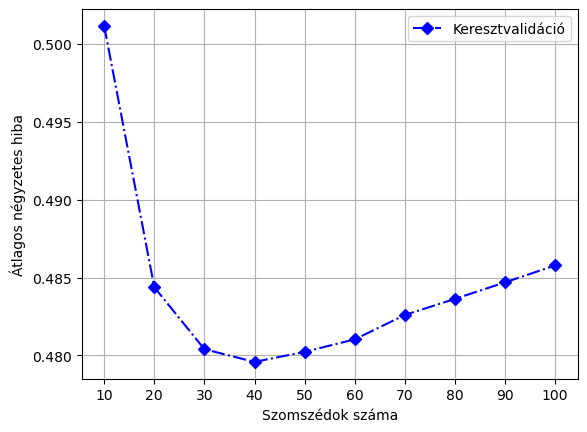

In [21]:
import matplotlib.pyplot as dg

átlag_teszt = abs(np.mean(teszt, axis=1))
x_tengelyfelirat_címkék = range(10, 101, 10)
x_tengelyfelirat_értékek = range(0, 
        len(x_tengelyfelirat_címkék))
dg.plot(x_tengelyfelirat_értékek, átlag_teszt, 'bD-.',
        label='Keresztvalidáció')
dg.grid()
dg.xlabel('Szomszédok száma')
dg.xticks(x_tengelyfelirat_értékek, x_tengelyfelirat_címkék)
dg.ylabel('Átlagos négyzetes hiba')
dg.legend(loc='upper right', numpoints=1)
dg.show()

## Próbáljuk ki a véletlenszerűsített keresést

In [22]:
%%time
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

keresés = HalvingGridSearchCV(
      estimator=knn_modell, 
      param_grid=param_rács,
      scoring=pontozási_metrika, 
      n_jobs=-1, 
      refit=True,
      return_train_score=True, 
      cv=10, 
      factor=2,
      max_resources='auto', 
      aggressive_elimination=True,
      random_state=42)

keresés.fit(ak_X.loc[:, jellemzőmaszk], y)
print(f"Legjobb paraméterek: {keresés.best_params_}")
legjobb_pontszám = abs(keresés.best_score_)
print(f"A legjobb paraméterek keresztvalidációs átlagos négyzetes hibája: {legjobb_pontszám:.3f}")


Legjobb paraméterek: {'metric': 'cosine', 'n_neighbors': 50, 'weights': 'distance'}
A legjobb paraméterek keresztvalidációs átlagos négyzetes hibája: 0.481
CPU times: total: 3.38 s
Wall time: 1min 28s


In [23]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_rács = {'n_neighbors': range(1, 100),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'cosine']
             }

véletlen_keresés = RandomizedSearchCV(
    estimator=knn_modell, 
    param_distributions=param_rács, 
    n_iter=10,
    cv=10,
    scoring=pontozási_metrika,
    refit=True, 
    random_state=0,
    n_jobs=-1
)

véletlen_keresés.fit(ak_X.loc[:, jellemzőmaszk], y)
print(f"Legjobb paraméterek: {véletlen_keresés.best_params_}")
legjobb_pontszám = abs(véletlen_keresés.best_score_)
print(f"A legjobb paraméterek keresztvalidációs átlagos négyzetes hibája: "
      f"{legjobb_pontszám:.3f}")

Legjobb paraméterek: {'weights': 'distance', 'n_neighbors': 37, 'metric': 'cosine'}
A legjobb paraméterek keresztvalidációs átlagos négyzetes hibája: 0.480
CPU times: total: 578 ms
Wall time: 10.7 s
